In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from tqdm import tqdm
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, log_loss
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

2025-09-03 12:16:14.662065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# adding the images, labels, styles 
file_path = "../raw_data/data_sampling200_topstyles.csv"
df = pd.read_csv(file_path)
df.head()


,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
0,Eleanor Fortescue-Brickdale,Romanticism,Romanticism,"['Middleages', 'Prophet']",https://www.wikiart.org/en/eleanor-fortescue-b...,https://uploads0.wikiart.org/00289/images/elea...,52663-efb-1910-p127-elizabeth-prayed-to-god-to...,['illustration'],NaN,NaN
1,Pierre-Paul Prud'hon,Romanticism,Neoclassicism,"['female-portraits', 'mother-and-child', 'Lady']",https://www.wikiart.org/en/pierre-paul-prud-ho...,https://uploads8.wikiart.org/images/pierre-pau...,31660-untitled.jpg,['portrait'],Untitled,XVIII-XIX cent.
2,Sorin Dumitrescu,Surrealism,Neo-Orthodoxism,['Table'],https://www.wikiart.org/en/sorin-dumitrescu/il...,https://uploads7.wikiart.org/images/sorin-dumi...,243190-illustration-for-nichita-stanescu-s-kno...,['illustration'],Illustration for Nichita Stanescu's Knots and ...,1982
3,Edouard Cortes,Post-Impressionism,Post-Impressionism,"['streets-and-squares', 'houses-and-buildings'...",https://www.wikiart.org/en/edouard-cortes/tuil...,https://uploads4.wikiart.org/images/edouard-co...,124633-tuileries-garden-1.jpg,['cityscape'],NaN,NaN
4,Eugene Delacroix,Romanticism,Romanticism,"['famous-people', 'Louis-de-Bourbon', 'Bishop-...",https://www.wikiart.org/en/eugene-delacroix/th...,https://uploads0.wikiart.org/images/eugene-del...,39529-the-assassination-of-the-bishop-of-liege...,['history painting'],NaN,NaN


In [17]:
def load_and_resize_images(image_dir):
    """
    Charge toutes les images d'un dossier, les redimensionne en conservant le ratio
    avec padding noir et les retourne sous forme de tableau NumPy.
    
    Args:
        image_dir (str): Chemin vers le dossier contenant les images.
        target_size (tuple): Taille finale des images (largeur, hauteur).
        
    Returns:
        np.ndarray: Tableau de forme (n_images, hauteur, largeur, canaux)
    """
    images_list = []
    
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path).convert('RGB') 

            img_resized = img.resize((128, 128), Image.BICUBIC)
            
            # convert into an array and add to list 
            img_array = np.array(img_resized)
            images_list.append(img_array)
    
    # Convertir la liste en tableau NumPy
    images_np = np.stack(images_list)
    return images_np

In [18]:
image_dir = "../raw_data/sample"
images_np = load_and_resize_images(image_dir)

In [25]:
X = np.array(images_np, dtype='float32') / 255.0

In [20]:
y = df['style']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      
    random_state=42,
    stratify=y
)

In [27]:
### Normalizing pixels' intensities
X_train = X_train / 255.
X_test = X_test / 255.

In [31]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [35]:
### Encoding the labels
y_train_cat = to_categorical(y_train_encoded, 10).astype('float32')
y_test_cat = to_categorical(y_test_encoded, 10).astype('float32')

In [36]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [39]:
def load_model():
    model = ResNet50(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model


In [37]:
model = load_model()
model = set_nontrainable_layers(model)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [42]:

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer1 = layers.Dense(500, activation='relu')
    dense_layer2 = layers.Dense(250, activation='relu')

    prediction_layer = layers.Dense(10, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        dense_layer2,
        prediction_layer
    ])
    return model

In [43]:
model = add_last_layers(model)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    16,384,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,099,972 (152.97 MB)

 Trainable params: 16,512,260 (62.99 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [47]:
def build_model():
    # $CHALLENGIFY_BEGIN    
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [49]:
model = build_model()

In [53]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(X_train, y_train_cat, 
                    validation_split=0.1, 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[es])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 775ms/step - accuracy: 0.1190 - loss: 2.3502 - val_accuracy: 0.2857 - val_loss: 2.0656
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.1667 - loss: 2.1561 - val_accuracy: 0.2143 - val_loss: 2.1871
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - accuracy: 0.1746 - loss: 2.1458 - val_accuracy: 0.0000e+00 - val_loss: 2.1635
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step - accuracy: 0.1746 - loss: 2.1406 - val_accuracy: 0.2857 - val_loss: 2.1262
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step - accuracy: 0.1667 - loss: 2.1356 - val_accuracy: 0.2143 - val_loss: 2.1278
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 510ms/step - accuracy: 0.1746 - loss: 2.1381 - val_accuracy: 0.2857 - val_loss: 2.1671
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


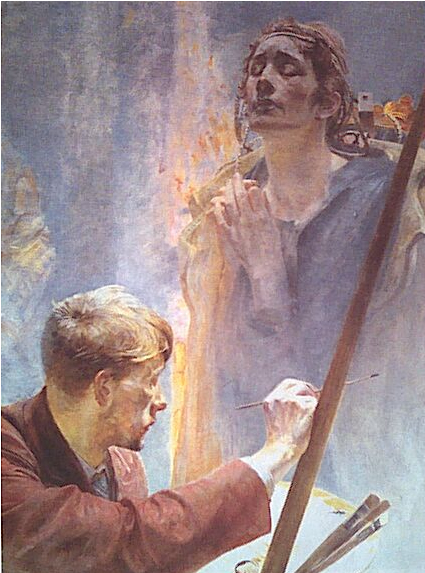

In [64]:
from PIL import Image
import os

# Chemin vers le dossier contenant l'image
image_path = "../raw_data/artist-and-muse.jpg"

from PIL import Image
img = Image.open(image_path)
img

In [65]:
img_array = np.array(img) 
img_array.shape

(573, 425, 3)

In [66]:
# Redimensionner à 128x128
img_resized = img.resize((128, 128), Image.BICUBIC)

# Convertir en array si besoin
import numpy as np
img_array_resized = np.array(img_resized)
print(img_array_resized.shape)

(128, 128, 3)


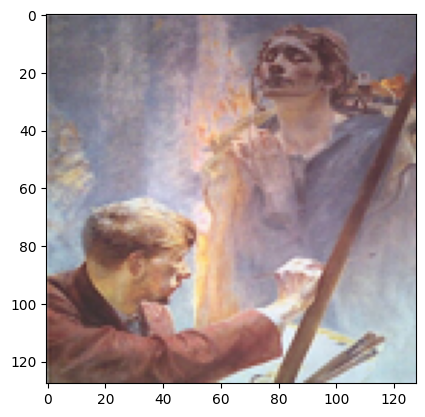

In [59]:
plt.imshow(img_resized)

In [68]:
y_pred = model.predict(img_array_resized.reshape(1, 128, 128, 3))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


array([[3.3618053e-03, 1.4429494e-02, 7.1198540e-03, 2.2823059e-03,
        4.0611852e-04, 2.4642507e-04, 5.3211424e-04, 3.5955291e-03,
        1.1479864e-02, 9.5654643e-01]], dtype=float32)

In [71]:
df[df["file_name"].str.contains("artist-and-muse.jpg")]

,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
95,Jacek Malczewski,Symbolism,Symbolism,"['allegories-and-symbols', 'arts-and-crafts', ...",https://www.wikiart.org/en/jacek-malczewski/ar...,https://uploads2.wikiart.org/images/jacek-malc...,81870-artist-and-muse.jpg,['symbolic painting'],NaN,NaN


In [ ]:
Jacek Malczartist-andewski,Symbolism,Symbolism,"['allegories-and-symbols', 'arts-and-crafts', 'male-portraits', 'female-portraits']",https://www.wikiart.org/en/jacek-malczewski/-muse,https://uploads2.wikiart.org/images/jacek-malczewski/artist-and-muse.jpg,81870-artist-and-muse.jpg,['symbolic painting'],,


In [70]:
list_styles = df['style'].unique().tolist()
list_styles

['Romanticism',
 'Surrealism',
 'Post-Impressionism',
 'Impressionism',
 'Realism',
 'Expressionism',
 'Abstract Expressionism',
 'Cubism',
 'Symbolism',
 'Neoclassicism']